In [61]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import spatial
from tqdm.auto import tqdm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

In [2]:
THREADS = 8

In [4]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/warp_model_300_epochs_30_el_slim.pkl')

## Precision

In [6]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/slim_interactions.npz')

In [ ]:
# Super time-consuming: https://github.com/lyst/lightfm/issues/510
precision_at_k(model, interactions, k=5, num_threads=THREADS).mean()

## ABX (only popular)

In [7]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')
abx_tests = pd.read_json('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', lines=True)

In [10]:
def get_item_embedding(model, dataset, asin):
    item_id = dataset.mapping()[2][asin]
    return model.item_embeddings[item_id]

In [13]:
A = np.zeros((10000, 30))
B = np.zeros((10000, 30))
X = np.zeros((10000, 30))

In [14]:
for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, dataset, test["A"])
    B[i, :] = get_item_embedding(model, dataset, test["B"])
    X[i, :] = get_item_embedding(model, dataset, test["X"])

0it [00:00, ?it/s]

In [15]:
dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

In [17]:
(dist_A < dist_B).mean()

0.5552

In [20]:
cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)
for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
(cos_dist_A < cos_dist_B).mean()

0.5789

## Suits & dresses ABX

In [23]:
abx_tests = pd.read_json('/pio/scratch/1/i313924/data/test_data/Suits_Dresses_ABX.json', lines=True)

A = np.zeros((10000, 30))
B = np.zeros((10000, 30))
X = np.zeros((10000, 30))

for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, dataset, test["A"])
    B[i, :] = get_item_embedding(model, dataset, test["B"])
    X[i, :] = get_item_embedding(model, dataset, test["X"])

dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

print((dist_A < dist_B).mean())

cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)

for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

print((cos_dist_A < cos_dist_B).mean())

0it [00:00, ?it/s]

0.5146


  0%|          | 0/10000 [00:00<?, ?it/s]

0.5204


## Embeddings PCA

In [24]:
item_embeddings = pd.DataFrame(model.item_embeddings)
user_embeddings = pd.DataFrame(model.user_embeddings)

In [25]:
embeddings = pd.concat([item_embeddings, user_embeddings], keys=['items', 'users'])

In [26]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [ ]:
tsne = TSNE(n_components=2, verbose=11, n_jobs=2, n_iter=450)
tsne_reduced_item_embeddings = tsne.fit_transform(item_embeddings[:10000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 4.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.613958
[t-SNE] Computed conditional probabilities in 0.486s
[t-SNE] Iteration 50: error = 93.1511230, gradient norm = 0.0000002 (50 iterations in 179.618s)


In [27]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

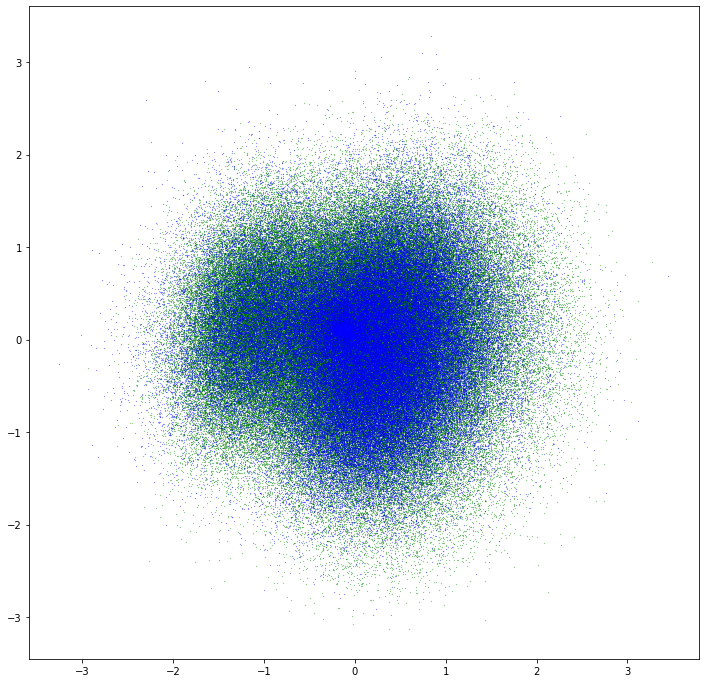

In [28]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [29]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [30]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [31]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [32]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [33]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

In [ ]:
tsne_reduced_item_embeddings = tsne_reduced_item_embeddings.join(categories.set_index('asin'))
tsne_reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


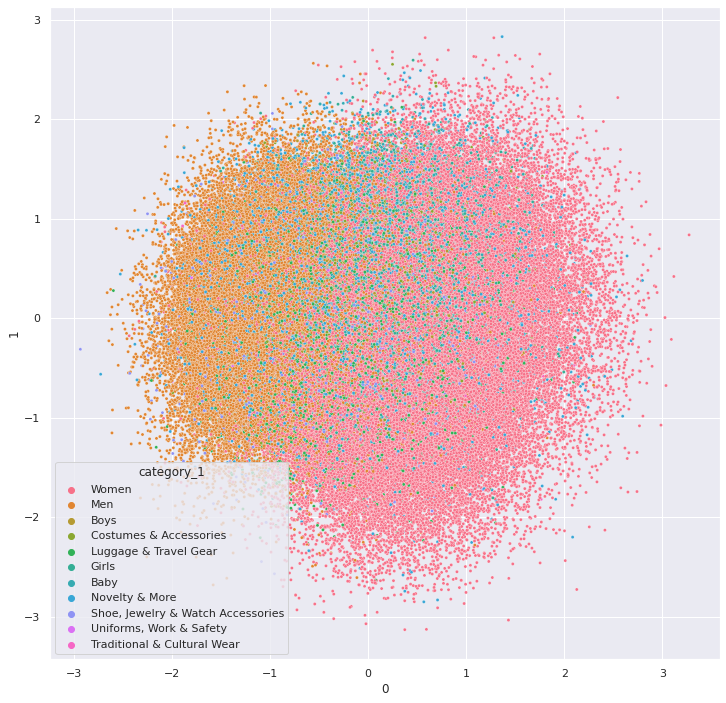

In [34]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

In [ ]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=tsne_reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

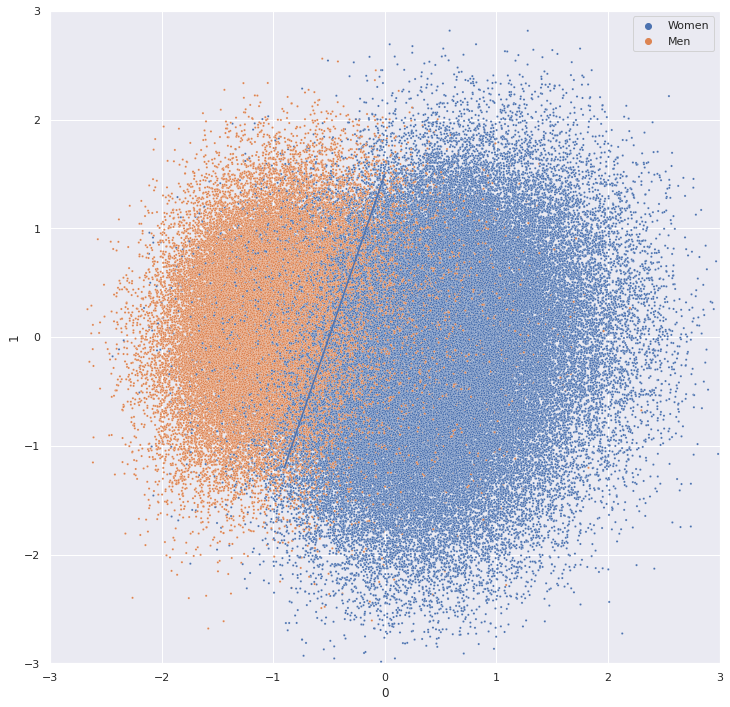

In [58]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
# y = 3x + 1.5
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

<AxesSubplot:xlabel='0', ylabel='1'>

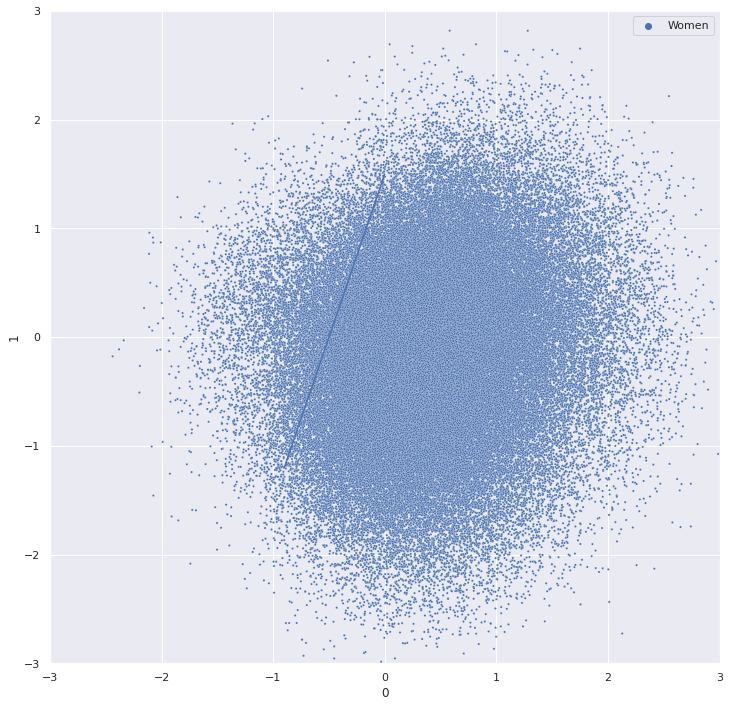

In [59]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

<AxesSubplot:xlabel='0', ylabel='1'>

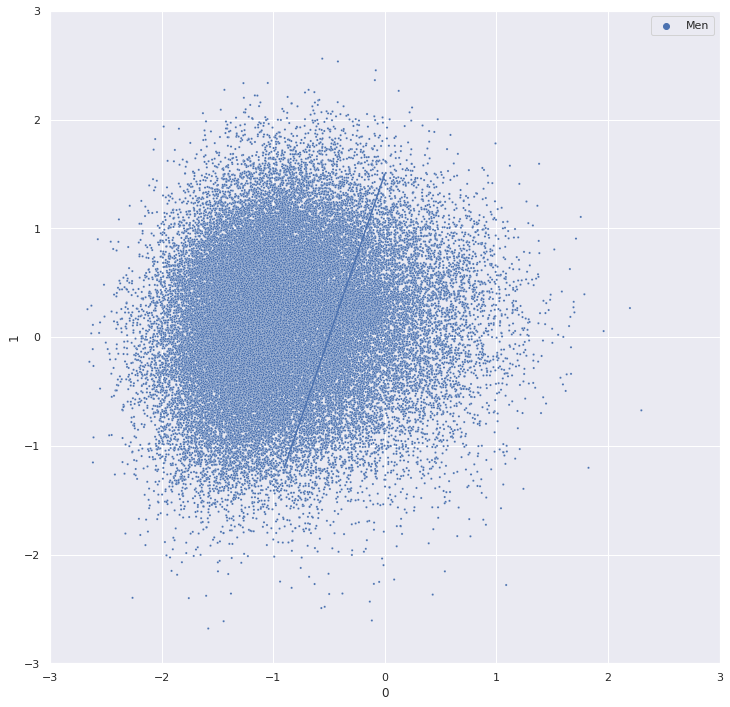

In [60]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin([ 'Men'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

In [38]:
women_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Women']
men_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Men']

In [39]:
left_women = women_embeddings[3*women_embeddings['0'] + 1.5 < women_embeddings['1']]
right_women = women_embeddings[3*women_embeddings['0'] + 1.5 > women_embeddings['1']]

In [40]:
left_men = men_embeddings[3*men_embeddings['0'] + 1.5 < men_embeddings['1']]
right_men = men_embeddings[3*men_embeddings['0'] + 1.5 > men_embeddings['1']]

In [41]:
len(left_women)/len(women_embeddings) * 100

7.978801276608204

In [42]:
len(right_men)/len(men_embeddings) * 100

24.780930322331596

## KNN

In [43]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)

In [44]:
samples = reduced_item_embeddings[['0', '1']].to_numpy()

In [45]:
neigh.fit(samples)

NearestNeighbors(n_neighbors=4)

In [46]:
women_nns = {}
for i in tqdm(range(len(women_embeddings))):
    women_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(women_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/102459 [00:00<?, ?it/s]

In [47]:
women_not_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is None or women_count < 2:
        women_not_nearest += 1

In [48]:
women_not_nearest / len(women_embeddings) * 100

30.89723694355791

In [49]:
men_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is not None and men_count >= 2:
        men_nearest += 1

In [50]:
men_nearest / len(women_embeddings) * 100

6.64656106344977

In [53]:
men_nns = {}
for i in tqdm(range(len(men_embeddings))):
    men_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(men_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/51810 [00:00<?, ?it/s]

In [54]:
men_not_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is None or men_count < 2:
        men_not_nearest += 1

In [55]:
men_not_nearest / len(men_embeddings) * 100

40.65238370970855

In [56]:
women_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is not None and women_count >= 2:
        women_nearest += 1

In [57]:
women_nearest / len(men_embeddings) * 100

16.245898475197837